## Importing Libraries and data:

In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
%matplotlib inline

from imblearn.over_sampling import SMOTE

smote = SMOTE()

SEED = 42

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

sns.set(rc={'figure.figsize':(11.7,8.27)})

def plot_important_features(model):    
    df = pd.DataFrame(zip(model.feature_importances_, X_train))
    df = df.sort_values(0, ascending=False)
    ax = sns.barplot(x=0, y=1, data=df)
    ax.set(xlabel='Feature Importance', ylabel='Feature Names')
    ax.set_title('Random Forest Feature Importance')

def print_metrics(labels, preds, scaled_data_test, y_train, y_hat_train):
 
        plot_confusion_matrix(clf, scaled_data_test, y_test, values_format='.3g')
        
        print('Training Precision: ', precision_score(y_train, y_hat_train, average='macro'))
        print('Testing Precision: ', precision_score(labels, preds, average='macro'))
        print('Training Recall: ', recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall: ', recall_score(labels, preds, average='macro'))
        print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
        print('Testing Accuracy: ', accuracy_score(labels, preds))
        print('Training F1-Score: ', f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score: ', f1_score(labels, preds, average='macro'))

In [3]:
df = pd.read_csv('Data/churm_data_cleaned.csv')
df.head()#in the churn column True = 0, False = 1
#in the international plan and voice mail plan columns, yes = 0, no = 1

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,1,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1
1,107,415,1,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1
2,137,415,1,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,1
3,84,408,0,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1
4,75,415,0,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1


In [4]:
y = df['churn']
X = df.drop('churn', axis=1, inplace=False)

## Train-Test Split:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=SEED)

## Scaling Data:

In [6]:
scaler = StandardScaler()

scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)  

## Resmapling Data:

In [7]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({1: 2284, 0: 382})


In [8]:
#Using Tomek Links to establish well defined clusters in the data
tl = TomekLinks()
X_res, y_res = tl.fit_resample(scaled_data_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2212, 0: 382})


In [9]:
X_res, y_res = tl.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2198, 0: 382})


In [10]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_res, y_res)

## Fitting the Model:

In [11]:
#Creating the classifier
clf = RandomForestClassifier()

# Fit the classifier
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)
train_preds = clf.predict(X_train_resampled)

Training Precision:  1.0
Testing Precision:  0.9050088183421516
Training Recall:  1.0
Testing Recall:  0.9017073085400413
Training Accuracy:  1.0
Testing Accuracy:  0.9505247376311844
Training F1-Score:  1.0
Testing F1-Score:  0.9033473409650775


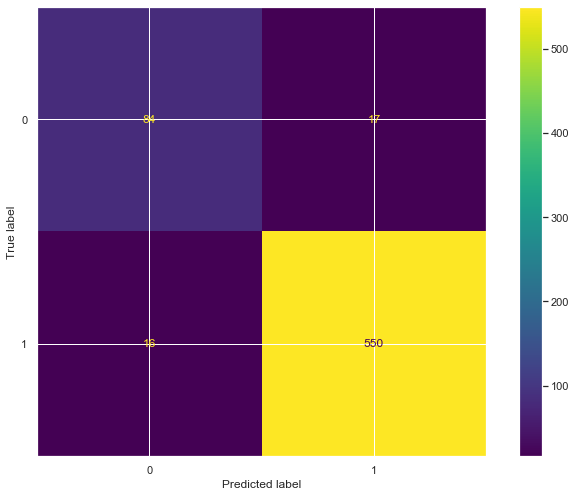

In [12]:
#After checking the scores there seems too be overfitting
print_metrics(y_test, test_preds, scaled_data_test, y_train_resampled, train_preds)

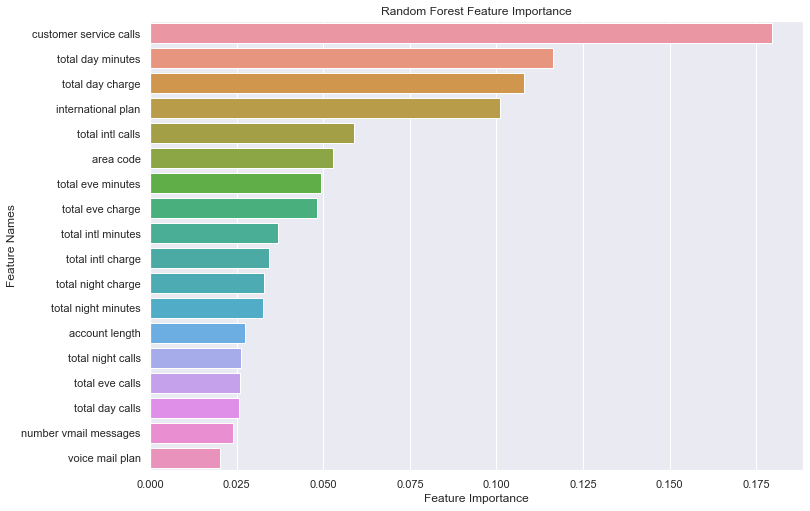

In [14]:
#Taking a look at the most important features
plot_important_features(clf)

## Optimizing with GridSearch

In [15]:
clf = RandomForestClassifier()
parameters = {
     "n_estimators"    : [5, 10, 12, 14],
     "criterion": ['gini', 'entropy'],
     "max_depth"        : [ 3, 4, 5, 15, 20, 25],
     "min_samples_leaf" : [ 1, 3, 5],
     "min_weight_fraction_leaf" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "max_leaf_nodes"   : [5, 80, 90, 100, 120, 'None']
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="recall",
                    cv=3,
                    return_train_score=True)

grid.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 15, 20, 25],
                         'max_leaf_nodes': [5, 80, 90, 100, 120, 'None'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [5, 10, 12, 14]},
             return_train_score=True, scoring='recall')

In [16]:
#Looking for the most optimal parameters
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'max_leaf_nodes': 120,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 14}

In [17]:
#taking a look at the most important features
grid.best_estimator_.feature_importances_

array([0.02475055, 0.04954411, 0.10479197, 0.0166456 , 0.02430744,
       0.10328101, 0.02281388, 0.13436981, 0.0519708 , 0.02338314,
       0.05160515, 0.0298251 , 0.0191872 , 0.03018387, 0.03135356,
       0.0583404 , 0.04037002, 0.18327639])

## Refitting Model with the best parameters:

In [18]:
clf = RandomForestClassifier(criterion = 'entropy',
  max_depth = 19,
  max_leaf_nodes = 120,
  min_samples_leaf = 3,
  min_weight_fraction_leaf = 0.0,
  n_estimators = 12)

clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)
train_preds = clf.predict(X_train_resampled)

Training Precision:  0.9744936975829639
Testing Precision:  0.8814814814814815
Training Recall:  0.9742948134667879
Testing Recall:  0.8783717594374278
Training Accuracy:  0.974294813466788
Testing Accuracy:  0.9385307346326837
Training F1-Score:  0.9742921196011487
Testing F1-Score:  0.8799163933202478


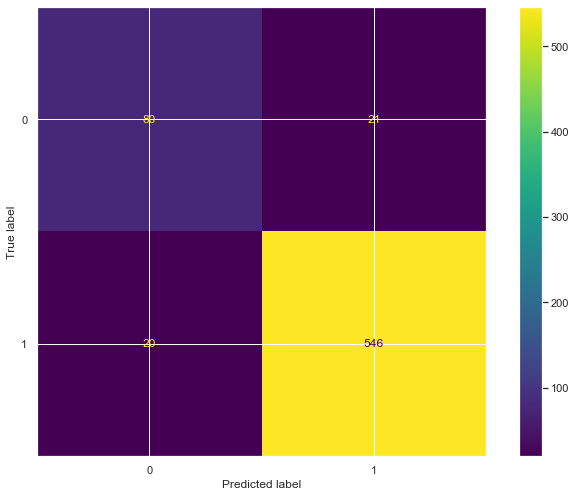

In [19]:
#Final testing scores are a littler lower then earlier but this model isnt as over fitted
print_metrics(y_test, test_preds, scaled_data_test, y_train_resampled, train_preds)

In [20]:
# #Looking at how the feature importances changed
# def plot_feature_importances(model):
#     n_features = X_train.shape[1]
#     plt.figure(figsize=(8,8))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')
#     plt.title("Random Forest Feature Importance")

# plot_feature_importances(clf)

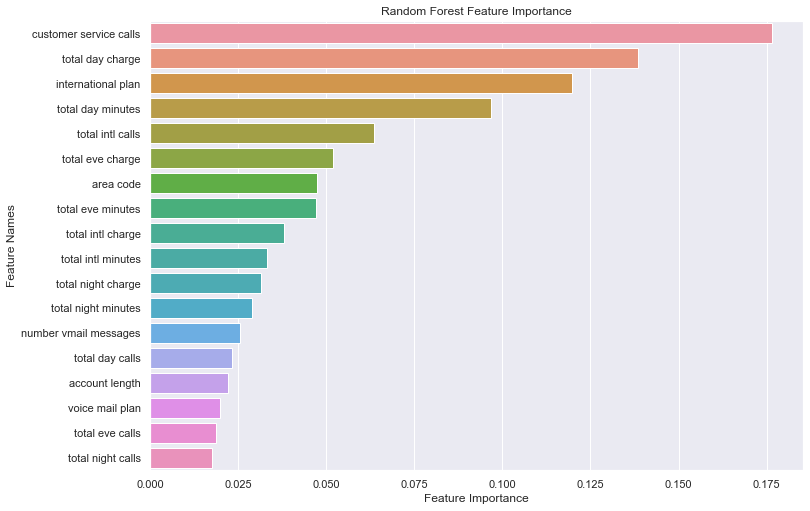

In [21]:
plot_important_features(clf)